In [1]:
import math
import pandas as pd
from langdetect import detect
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer
import math
import matplotlib.pyplot as plt

In [2]:
lem = WordNetLemmatizer() #create lemmatizer

In [3]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kseniapavlina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
dictionary = pd.read_csv('../data/processedDict.csv')
dictionary['word'] = dictionary['word'].apply(lambda x: lem.lemmatize(x, pos='n'))

In [5]:
dictionary

,word,cat_lev1,cat_lev2,cat_lev3,ndf
0,information,business,professional_conduct_host,advice,0.008904
1,recommendation,business,professional_conduct_host,advice,0.008375
2,tip,business,professional_conduct_host,advice,0.008399
3,advice,business,professional_conduct_host,advice,0.007568
4,suggestion,business,professional_conduct_host,advice,0.007580
...,...,...,...,...,...
347,talking,social,social_interaction,talking,0.001961
348,chatting,social,social_interaction,talking,0.001408
349,moment,social,social_interaction,talking,0.001155
350,chat,social,social_interaction,talking,0.000553


In [6]:
filepath = '../data/en_reviews/Manchester.csv'
reviews = pd.read_csv(filepath)

# reviews = reviews['date']
reviews

table = str.maketrans('', '', string.punctuation) #mapping to strip punctuation in review

#strip punct of each review -> lemmatise -> output is list of words so join into sentences
reviews['comments'] = reviews.comments.apply(lambda review: ' '.join(map(str, [lem.lemmatize(word.translate(table), pos='n') for word in review.lower().split()])))
reviews

reviews['date'] = pd.to_datetime(reviews['date'])

In [7]:
#### DELETE THIS LATER ###
mask = (reviews['date'] >= '2014-01-01') & (reviews['date'] < '2018-01-01')
reviews = reviews.loc[mask].copy()
reviews

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,langs
14,14,68951,10229418,2014-02-08,10652136,Justine,it a lovely house and awesome person you could...,en
15,15,68951,11050942,2014-03-18,9852319,Greg,all very nice clean and easy to check in and o...,en
16,16,68951,14658065,2014-06-23,10195882,Emma,we had a wonderful stay in peter and dellas lo...,en
17,17,68951,15670815,2014-07-14,13078630,David,we had the best experience in this house durin...,en
18,18,68951,17303401,2014-08-10,1669938,Libby,great accommodation warm welcome with a fridge...,en
...,...,...,...,...,...,...,...,...
86047,93324,22998816,120062317,2016-12-07,1584560,Phil,a whole flat for the price of a hotel room rea...,en
86048,93325,22998816,126358145,2017-01-11,30793292,David,i would recommend the heart for anyone working...,en
86049,93326,22998816,151327457,2017-05-12,127705440,Liam,ideal for what we needed 1 night close to old...,en
86050,93327,22998816,155425156,2017-05-28,33018033,Catherine,we stayed for one night at this location and f...,en


In [8]:
reviews

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,langs
14,14,68951,10229418,2014-02-08,10652136,Justine,it a lovely house and awesome person you could...,en
15,15,68951,11050942,2014-03-18,9852319,Greg,all very nice clean and easy to check in and o...,en
16,16,68951,14658065,2014-06-23,10195882,Emma,we had a wonderful stay in peter and dellas lo...,en
17,17,68951,15670815,2014-07-14,13078630,David,we had the best experience in this house durin...,en
18,18,68951,17303401,2014-08-10,1669938,Libby,great accommodation warm welcome with a fridge...,en
...,...,...,...,...,...,...,...,...
86047,93324,22998816,120062317,2016-12-07,1584560,Phil,a whole flat for the price of a hotel room rea...,en
86048,93325,22998816,126358145,2017-01-11,30793292,David,i would recommend the heart for anyone working...,en
86049,93326,22998816,151327457,2017-05-12,127705440,Liam,ideal for what we needed 1 night close to old...,en
86050,93327,22998816,155425156,2017-05-28,33018033,Catherine,we stayed for one night at this location and f...,en


In [9]:
def get_trends_nice(category, subcats):
    years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
    allwords = reviews['comments'].tolist()
    allwords = " ".join(allwords)
    unique_words = set(allwords.split(' '))
    len(unique_words)

    unique_words = list(unique_words)
    unique_words = [string for string in unique_words if string != ""]
#     len(unique_words)

    ls = []
    for word in unique_words:
        word = ''.join([i for i in word if not i.isdigit()])
        ls += [word]
    unique_words= ls
    unique_words = [string for string in unique_words if string != ""]
    unique_words = list(dict.fromkeys(unique_words))

    def countWords(word, review):
        count = 0
        for i in review:
            if i == word:
                count+=1
        return count

    def getDenom(review, unique_words):
        count = 0
        den = 0
        ls = []
        review = review.split()
        for word in review:
            kmp = countWords(word, review)
            if (kmp > 0 and word not in ls):
                ls += [word]
                den += math.log(1 + kmp)
        return den

    reviews['den'] = reviews['comments'].apply(lambda x: getDenom(x, unique_words))

    def getNom(category, review, dictionary, cat_levl="cat_lev1"):
        nom = 0
        review = review.split()
        dictionaryWords = dictionary[(dictionary[cat_levl] == category)]
        dictionaryWords = dictionaryWords['word']
        for word in dictionaryWords:
            nom += math.log(1 + review.count(word))
        return nom

    reviews['temp'] = reviews['comments'].apply(lambda x: getNom(category, x, dictionary))
    reviews[category] = reviews['temp']*100/reviews['den']

    k = {}
    for subcat in subcats:
        temp = reviews['comments'].apply(lambda x: getNom(subcat, x, dictionary, cat_levl="cat_lev3"))
        reviews[subcat] = temp * 100 / reviews["den"]
        k[subcat] = reviews[subcat].loc[reviews[subcat] > 0].min()
        
    print(k)
    
    k_business= reviews[category].loc[reviews[category] > 0]
    k_business = k_business.min()
    print(k_business)

    def adoptionForSetOfReviews(category, setOfReviews, dictionary, startDate, endDate, k):
        adoption = 1
        mask = (setOfReviews['date'] >= startDate) & (setOfReviews['date'] < endDate)
        setOfReviews = setOfReviews.loc[mask]
        setOfReviews = setOfReviews[category]
        if (len(setOfReviews) == 0):
            return 0
        else:
            b = 1/len(setOfReviews)
            for review in setOfReviews:
                adoption *= math.pow((review + k),b)
            adoption = adoption - k
            return adoption

    d2 = {'year' : years, 'value':0.0}
    out = pd.DataFrame(data=d2)
    
    for i in range(len(years)):
        out.at[i, "value_{}".format(category)] = adoptionForSetOfReviews(category, reviews, dictionary, "{}-01-01".format(years[i]), "{}-01-01".format(years[i] + 1), k_business)
        for subcat in subcats:
            out.at[i, "value_{}_{}".format(category, subcat)] = adoptionForSetOfReviews(subcat, reviews, dictionary, "{}-01-01".format(years[i]), "{}-01-01".format(years[i] + 1), k[subcat])

    return out

In [10]:
subcats = ["meal", "people", "personality_host", "talking", "sharing"]
soci = get_trends_nice("social", subcats)

{'meal': 0.30528239690480763, 'people': 0.3026747346414423, 'personality_host': 0.3093866502005734, 'talking': 0.3093866502005734, 'sharing': 0.3026747346414423}
0.3888016161205252


In [28]:
soci['coef'] = soci['value_social'] / (soci['value_social_meal'] + soci['value_social_people']+soci['value_social_personality_host'] + soci['value_social_talking'] + soci['value_social_sharing'])
soci

,year,value,value_social,value_social_meal,value_social_people,value_social_personality_host,value_social_talking,value_social_sharing,coef
0,2010,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
1,2011,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
2,2012,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
3,2013,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
4,2014,0.0,2.238989,0.150378,0.805129,0.425489,0.048726,0.076364,1.486629
5,2015,0.0,1.887042,0.112177,0.676786,0.377746,0.041282,0.080816,1.464177
6,2016,0.0,1.349454,0.081269,0.494965,0.303874,0.032202,0.056887,1.392342
7,2017,0.0,0.842126,0.052271,0.296047,0.235901,0.015548,0.032051,1.332862
8,2018,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
9,2019,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


In [29]:
soci['value_social_meal'] = soci['value_social_meal']*soci['coef']
soci['value_social_people'] = soci['value_social_people']*soci['coef']
soci['value_social_personality_host'] = soci['value_social_personality_host']*soci['coef']
soci['value_social_talking'] = soci['value_social_talking']*soci['coef']
soci['value_social_sharing'] = soci['value_social_sharing']*soci['coef']

soci

,year,value,value_social,value_social_meal,value_social_people,value_social_personality_host,value_social_talking,value_social_sharing,coef
0,2010,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2011,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2012,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2013,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,0.0,2.238989,0.223556,1.196928,0.632544,0.072437,0.113524,1.486629
5,2015,0.0,1.887042,0.164247,0.990934,0.553087,0.060444,0.118329,1.464177
6,2016,0.0,1.349454,0.113155,0.689160,0.423096,0.044837,0.079206,1.392342
7,2017,0.0,0.842126,0.069670,0.394590,0.314424,0.020723,0.042719,1.332862
8,2018,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
9,2019,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
a = pd.DataFrame(columns=["year", "subcat", "val"])

for subcat in subcats:
    ap = {"year": soci["year"], "val": soci["value_social_{}".format(subcat)]}
    ap = pd.DataFrame(data=ap)
    ap["subcat"] = subcat
    a = a.append(ap)
a

,subcat,val,year
0,meal,NaN,2010
1,meal,NaN,2011
2,meal,NaN,2012
3,meal,NaN,2013
4,meal,0.223556,2014
5,meal,0.164247,2015
6,meal,0.113155,2016
7,meal,0.069670,2017
8,meal,NaN,2018
9,meal,NaN,2019


In [33]:
pivot_social = a.pivot(index='year', columns='subcat', values='val')
pivot_social

subcat,meal,people,personality_host,sharing,talking
year,,,,,
2010,NaN,NaN,NaN,NaN,NaN
2011,NaN,NaN,NaN,NaN,NaN
2012,NaN,NaN,NaN,NaN,NaN
2013,NaN,NaN,NaN,NaN,NaN
2014,0.223556,1.196928,0.632544,0.113524,0.072437
2015,0.164247,0.990934,0.553087,0.118329,0.060444
2016,0.113155,0.689160,0.423096,0.079206,0.044837
2017,0.069670,0.394590,0.314424,0.042719,0.020723
2018,NaN,NaN,NaN,NaN,NaN


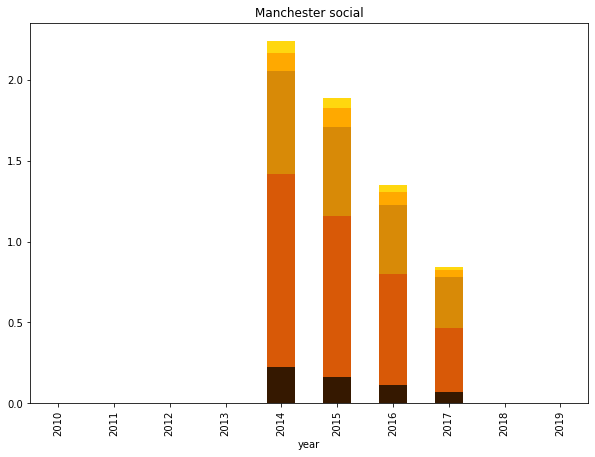

In [34]:
ax = pivot_social.loc[:,['meal','people', 'personality_host', 'sharing', 'talking']].plot.bar(stacked=True, figsize=(10,7), color=['#351800','#D85907','#D88A07','#FFA900','#FFD70F'])
plt.title("Manchester social")
ax.get_legend().remove()

In [20]:
business_subcats = ['location', 'communication', 'personality_host2', 'property_type', 'logistic', 'advice', 'facilities', 'interiors']
busi = get_trends_nice("business", business_subcats)

{'location': 0.566116900485664, 'communication': 0.31059423255865254, 'personality_host2': 0.3026747346414423, 'property_type': 0.35417438269375745, 'logistic': 0.31059423255865254, 'advice': 0.31059423255865254, 'facilities': 0.3143617291605593, 'interiors': 0.36420561789903516}
1.3639377332474265


In [22]:
busi['coef'] = busi['value_business'] / (busi['value_business_location'] + busi['value_business_communication']+busi['value_business_personality_host2'] + busi['value_business_property_type'] + busi['value_business_logistic']+busi['value_business_facilities'] + busi['value_business_advice']+busi['value_business_interiors'])
busi

,year,value,value_business,value_business_location,value_business_communication,value_business_personality_host2,value_business_property_type,value_business_logistic,value_business_advice,value_business_facilities,value_business_interiors,coef
0,2010,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
1,2011,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
2,2012,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
3,2013,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
4,2014,0.0,17.512259,4.740262,0.110200,0.937743,1.239785,0.221869,0.095032,0.094938,2.563424,1.750657
5,2015,0.0,17.536123,4.444161,0.125037,1.031686,1.279237,0.234603,0.104215,0.083101,2.544092,1.781017
6,2016,0.0,17.987175,4.616138,0.153869,0.803354,1.130260,0.217954,0.078107,0.078646,2.321648,1.913534
7,2017,0.0,18.453962,5.532170,0.179942,0.516827,0.853643,0.158211,0.056515,0.069230,2.000868,1.970018
8,2018,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
9,2019,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


In [24]:
busi['value_business_communication'] = busi['value_business_communication']*busi['coef']
busi['value_business_location'] = busi['value_business_location']*busi['coef']
busi['value_business_personality_host2'] = busi['value_business_personality_host2']*busi['coef']
busi['value_business_advice'] = busi['value_business_advice']*busi['coef']
busi['value_business_property_type'] = busi['value_business_property_type']*busi['coef']
busi['value_business_facilities'] = busi['value_business_facilities']*busi['coef']
busi['value_business_interiors'] = busi['value_business_interiors']*busi['coef']
busi['value_business_logistic'] = busi['value_business_logistic']*busi['coef']

busi

,year,value,value_business,value_business_location,value_business_communication,value_business_personality_host2,value_business_property_type,value_business_logistic,value_business_advice,value_business_facilities,value_business_interiors,coef
0,2010,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,0.0,17.512259,8.298570,0.192922,1.641666,2.170438,0.388416,0.166369,0.166204,4.487675,1.750657
5,2015,0.0,17.536123,7.915124,0.222692,1.837449,2.278342,0.417831,0.185609,0.148004,4.531070,1.781017
6,2016,0.0,17.987175,8.833138,0.294433,1.537246,2.162791,0.417062,0.149461,0.150492,4.442553,1.913534
7,2017,0.0,18.453962,10.898477,0.354488,1.018160,1.681692,0.311678,0.111335,0.136385,3.941746,1.970018
8,2018,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2019,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
a = pd.DataFrame(columns=["year", "subcat", "val"])

for subcat in subcats:
    ap = {"year": busi["year"], "val": busi["value_business_{}".format(subcat)]}
    ap = pd.DataFrame(data=ap)
    ap["subcat"] = subcat
    a = a.append(ap)
a

,subcat,val,year
0,advice,NaN,2010
1,advice,NaN,2011
2,advice,NaN,2012
3,advice,NaN,2013
4,advice,0.166369,2014
...,...,...,...
5,communication,0.222692,2015
6,communication,0.294433,2016
7,communication,0.354488,2017
8,communication,NaN,2018


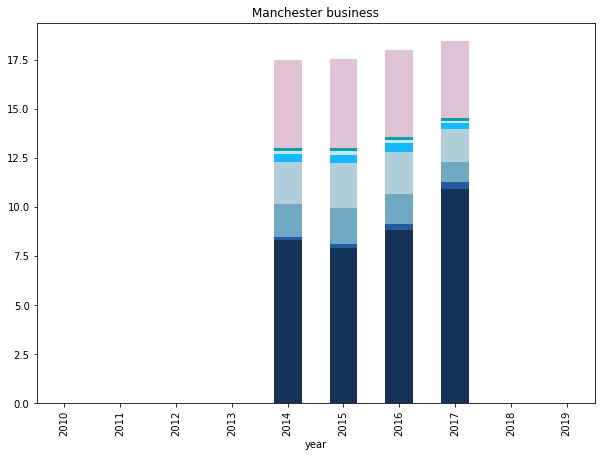

In [27]:
pivot_business = a.pivot(index='year', columns='subcat', values='val')
ax = pivot_business.loc[:, ['location', 'communication', 'personality_host2', 'property_type', 'logistic', 'advice', 'facilities', 'interiors']].plot.bar(stacked=True, figsize=(10,7), color=['#143258','#235BA0','#70A9C1','#B1CEDB','#16B9FF','#BCEBFF','#119DAF', '#DFC3D4'])
plt.title("Manchester business")
ax.get_legend().remove()